# Analysis of "Experiments on Emotional Inattention"


In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import math

def load_csv_files(subfolder_name):
    notebook_path = os.path.dirname(os.path.abspath('__file__'))
    data_folder_path = os.path.join(notebook_path, 'data', subfolder_name)

    all_dataframes = []
    
    # Get a list of all files in the subfolder
    files = os.listdir(data_folder_path)

    # Loop through each file and load it as a pandas DataFrame
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(data_folder_path, file)
            df = pd.read_csv(file_path)
            all_dataframes.append(df)

    # Concatenate all DataFrames into one, stacking them on top of each other
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    return combined_df

# Usage:
subfolder_name = '2023-07-pilot'
data = load_csv_files(subfolder_name)


# Remove duplicates based on all columns
data.drop_duplicates(inplace=True)

# restrict to sessions:
def restrict_to_sessions(data, session_codes):
    return data[data['session.code'].isin(session_codes)]

session_codes = ['pivyq19w']
if session_codes != []:
    data = restrict_to_sessions(data, session_codes)


# Drop all columns that do not begin with 'participant'
data = data.filter(regex='^participant.')

data.columns = data.columns.str.replace('participant.', '')



# List of pages to check against
pages_to_exclude = ['Welcome', 'Consent']

# Create a new column 'not_in_list' based on the condition
data['started_experiment'] = data['_current_page_name'].apply(lambda x: x not in pages_to_exclude and pd.notna(x))

# Create a new column 'finished_experiment' based on the condition
data['finished_experiment'] = data['_current_page_name'].apply(lambda x: x == 'Finished')


# Calculate the number of rows with 'finished_experiment' equal to True for each treatment
finished_experiment_count = data[data['finished_experiment'] == True].groupby('treatment').size()

# Calculate the number of rows with 'started_experiment' equal to True for each treatment
started_experiment_count = data[data['started_experiment'] == True].groupby('treatment').size()

# Calculate the ratio for each treatment
ratio_by_treatment = finished_experiment_count / started_experiment_count

print('Attrition by treatment: ',ratio_by_treatment)

print('Starters: ', started_experiment_count)

print('Finishers: ', finished_experiment_count)

# Filter the DataFrame to only include rows where 'finished_experiment' is True
data = data[data['finished_experiment'] == True]



# Convert the JSON strings to dictionaries
# Function to parse JSON strings while handling NaN values
def parse_dict_string(dict_string):
    # Check if the input is a string
    if not isinstance(dict_string, str):
        return np.NaN
    
    # Replace single quotes with double quotes before parsing as JSON
    corrected_dict_string = dict_string.replace("'", "\"")
    try:
        return json.loads(corrected_dict_string)
    except json.JSONDecodeError:
        return np.NaN

# Convert the JSON strings to dictionaries, handling NaN values
for column in ['times','mistakes','demographics']:
    data[column] = data[column].apply(parse_dict_string)

# Custom function to calculate the total from the 'mistakes' dictionary
def calculate_mistakes_total(mistakes_dict):
    # Check if the value is a dictionary
    if isinstance(mistakes_dict, dict):
        # Extract the values from the dictionary and sum them
        total = sum(mistakes_dict.values())
        return total
    else:
        return None

# Apply the custom function to create the new column 'mistakes_total'
data['mistakes_total'] = data['mistakes'].apply(calculate_mistakes_total)

data = pd.concat([data,
                 data['times'].apply(pd.Series),
                 data['mistakes'].apply(pd.Series),
                 data['demographics'].apply(pd.Series)], axis=1)
# Custom converter function to convert array strings to actual arrays
def parse_array_string(array_string):
    try:
        return ast.literal_eval(array_string)
    except (SyntaxError, ValueError):
        return np.NaN
    
data['experiment_sequence'] = data['experiment_sequence'].apply(parse_array_string)

data['sequence'] = data['sequence'].apply(parse_array_string)


# Function to calculate maximum of first N elements in a list
def max_first_n(lst, n):
    return max(lst[:n])

# Calculate the time difference and create a new column 'task_duration'
data['task_duration'] = data['end_task'] - data['start_task']

# Calculate the time difference and create a new column 'task_duration'
data['study_duration'] = data['finished'] - data['start']



# Select only the desired columns
selected_columns = ['label','feedback', 'treatment', 'payoff', 'study_duration']
selected_data = data[selected_columns]

# Create the 'output' folder if it doesn't exist
output_folder = os.path.join(os.getcwd(), 'output')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create the 'subfolder' inside the 'output' folder if it doesn't exist
subfolder_path = os.path.join(output_folder, subfolder_name)
if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'feedback.csv')
selected_data.to_csv(file_path, index=False)


Attrition by treatment:  treatment
bonus      0.923077
penalty    1.000000
dtype: float64
Starters:  treatment
bonus      13
penalty    12
dtype: int64
Finishers:  treatment
bonus      12
penalty    12
dtype: int64


In [7]:
# Step 1: Create a list of strings in the required format
rows_as_text = [f"{label},{bonus_payment}" for label, bonus_payment in zip(data['label'], data['bonus_payment'])]

# Step 2: Write the strings to a text file
with open('bonus_payment.txt', 'w') as file:
    file.write("\n".join(rows_as_text))




# Step 1: Create a list of strings in the required format
rows_as_text = [f"{label}" for label in data['label']]

# Step 2: Write the strings to a text file
with open('approved.txt', 'w') as file:
    file.write("\n".join(rows_as_text))

In [8]:
data[['num_draws','treatment','task_duration','study_duration','label','mistakes_total','mistakes','feedback']]


# average_by_group = data.groupby('treatment')['mistakes_total'].mean()

# data['payment_B']

# for el in ['payment_B','bonus','bonus_change']  + [ 'payment_P','penalty','penalty_change']:
#     print(data.groupby('treatment')[el].mean())




,num_draws,treatment,task_duration,study_duration,label,mistakes_total,mistakes,feedback
0,1.0,bonus,46.050174,332.301738,608f2b2239ba31bad6a074f7,2,"{'payment_B': 0, 'bonus': 0, 'bonus_change': 2}",NaN
1,30.0,penalty,469.912404,733.873258,61036b968e883dc6b02687e4,5,"{'payment_P': 1, 'penalty': 1, 'penalty_change...",NaN
2,457.0,bonus,7004.506987,7154.071983,62acf9ee829033db9be5ef1b,6,"{'payment_B': 0, 'bonus': 1, 'bonus_change': 5}",NaN
3,10.0,penalty,150.133608,322.378106,5adf874e066c510001d454f5,1,"{'payment_P': 0, 'penalty': 0, 'penalty_change...",It was fun; felt a little like gambling.
4,5.0,bonus,130.520235,313.257282,610894aa34911651136a1c97,1,"{'payment_B': 0, 'bonus': 0, 'bonus_change': 1}",fun
5,4.0,penalty,99.981141,438.411315,62686fdb4b7b799abadf0303,2,"{'payment_P': 1, 'penalty': 0, 'penalty_change...",There wasn't anything confusing but I felt lik...
6,48.0,bonus,551.718282,703.824219,5ec20598203e9e2e8a2855e0,1,"{'payment_B': 0, 'bonus': 0, 'bonus_change': 1}",NaN
7,9.0,penalty,136.443663,311.647384,5bcded8f2d94a8000133e068,3,"{'payment_P': 0, 'penalty': 0, 'penalty_change...",NaN
8,121.0,bonus,1513.322322,1684.060109,612274842d4805447451f87b,1,"{'payment_B': 0, 'bonus': 0, 'bonus_change': 1}",NaN
9,10.0,penalty,227.110362,437.522838,644329db047ca34e6f0e4697,8,"{'payment_P': 0, 'penalty': 0, 'penalty_change...",NaN


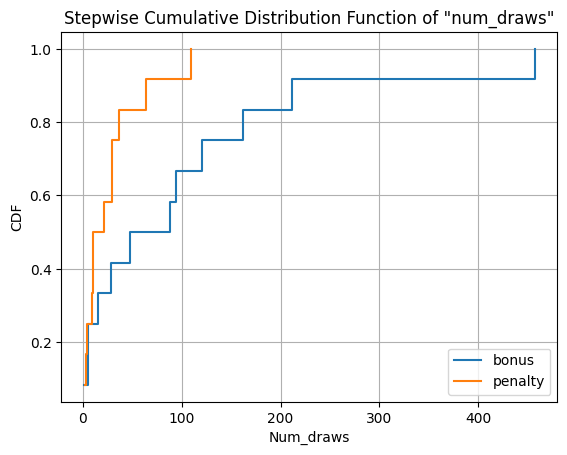

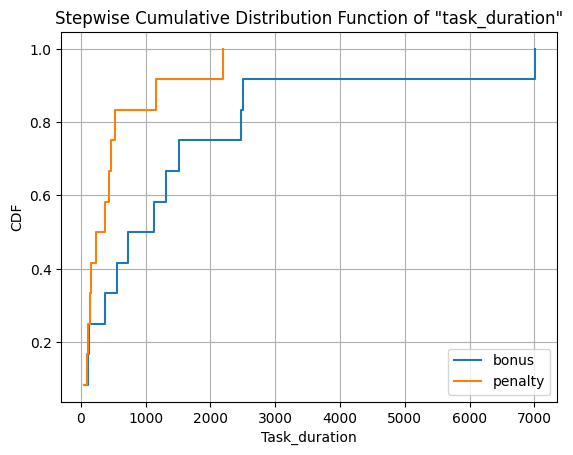

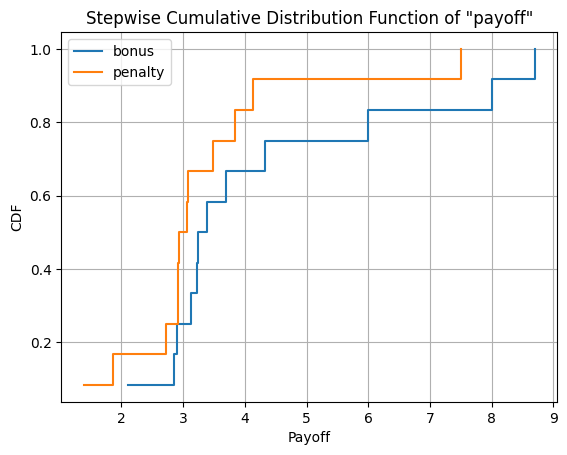

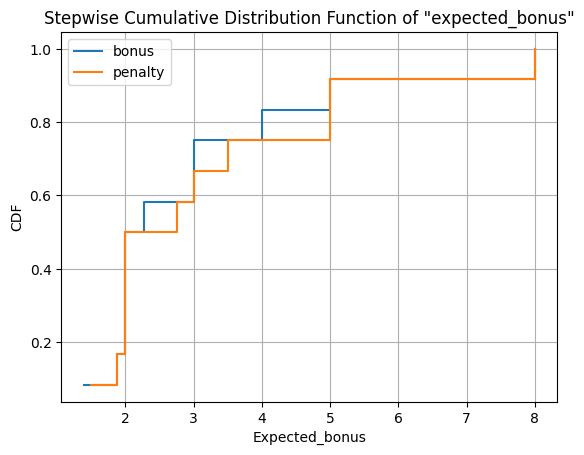

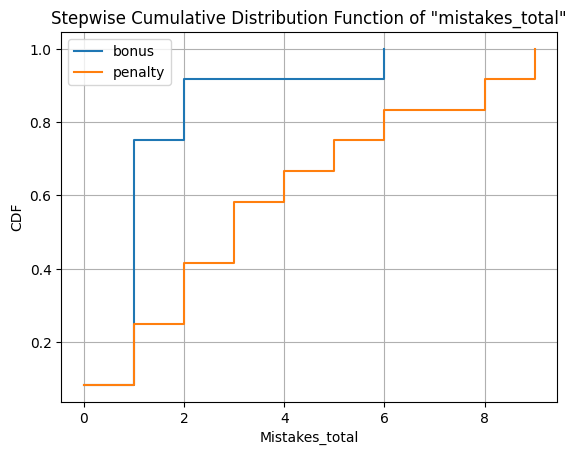

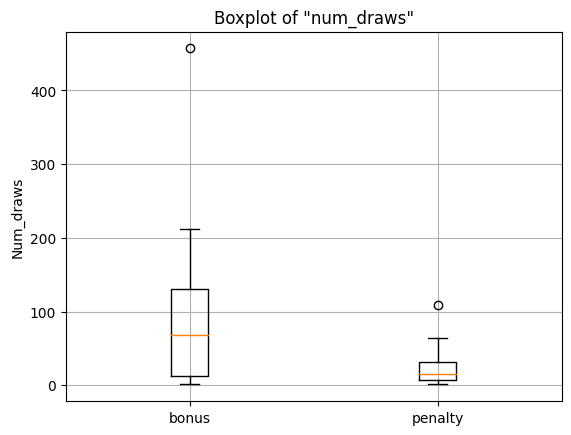

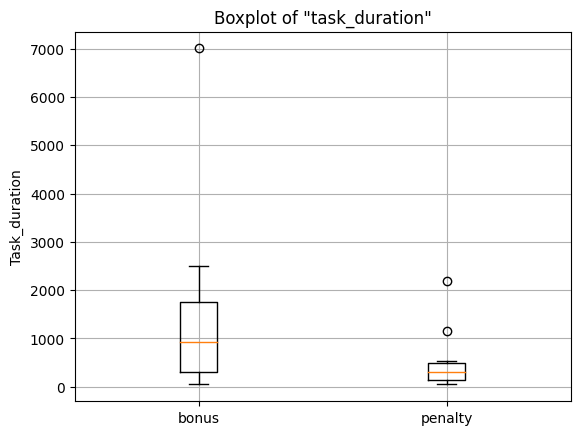

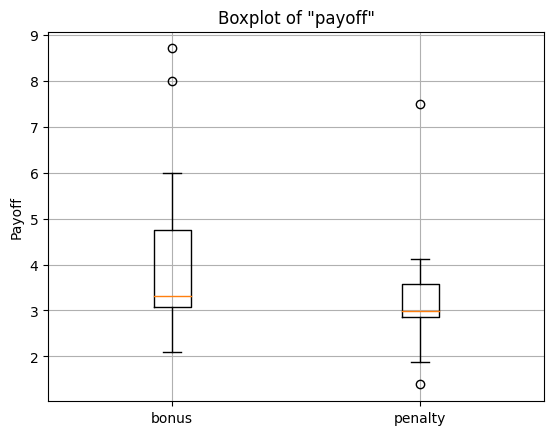

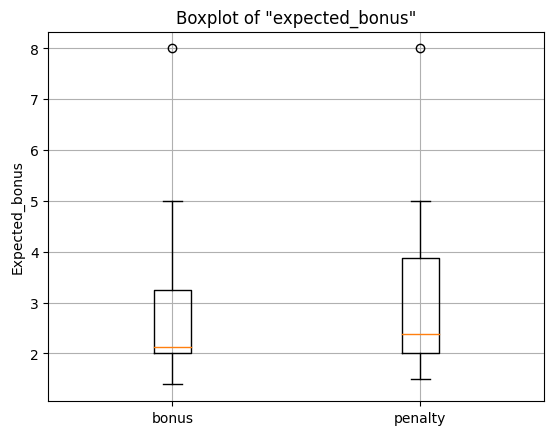

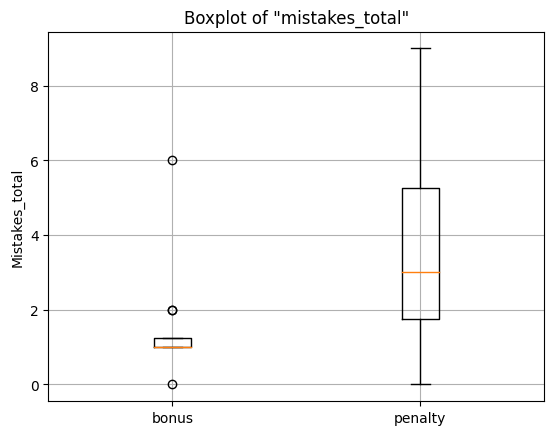

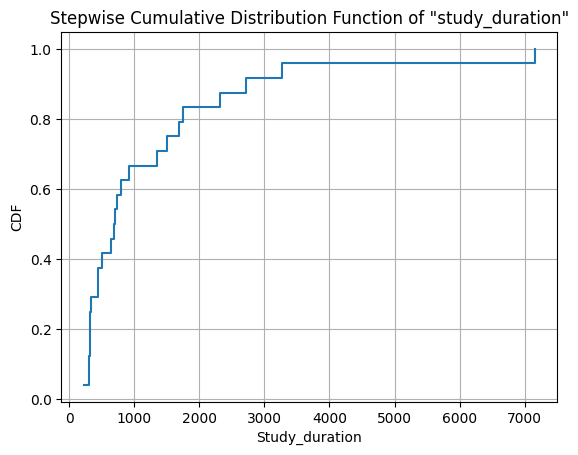

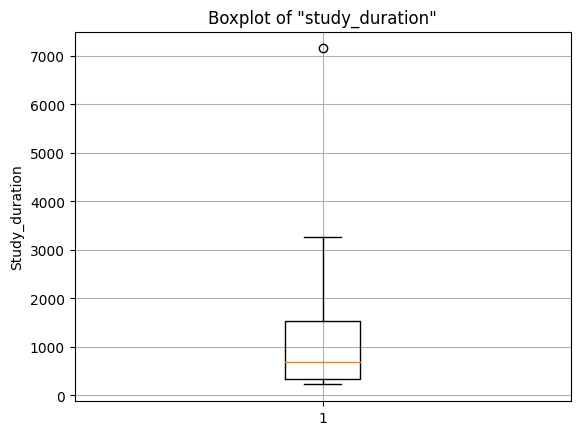

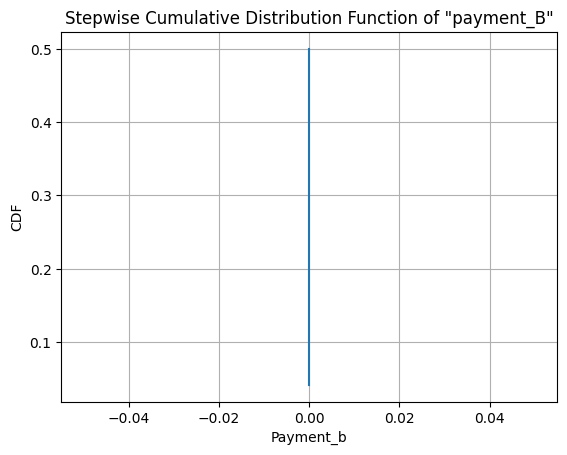

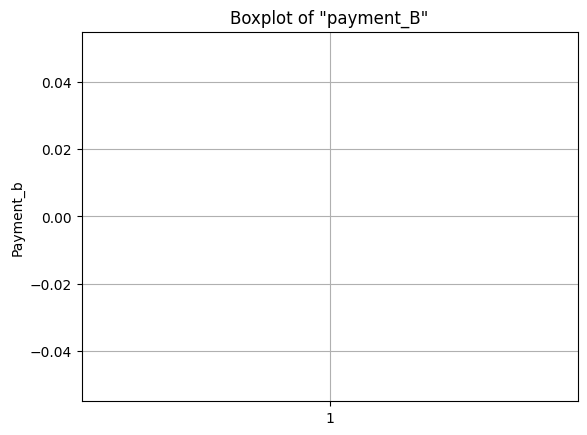

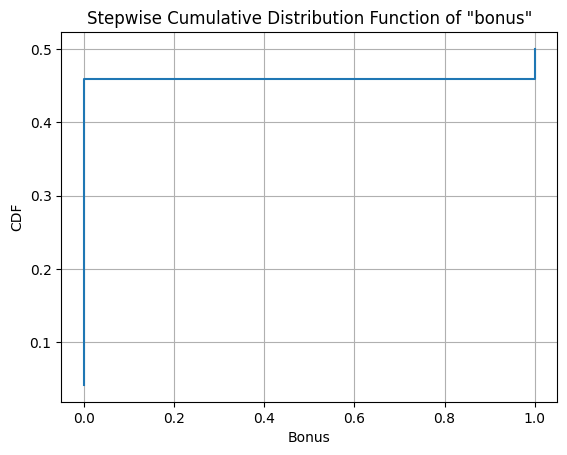

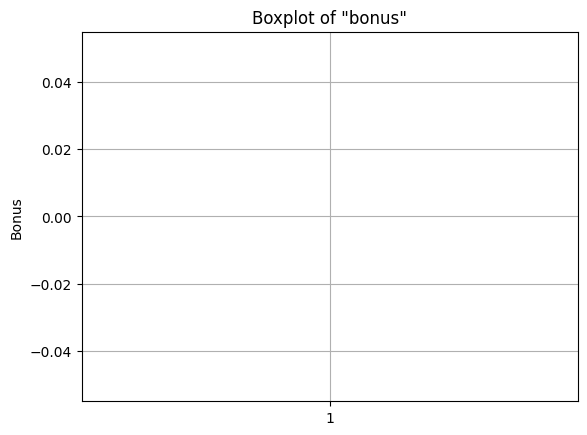

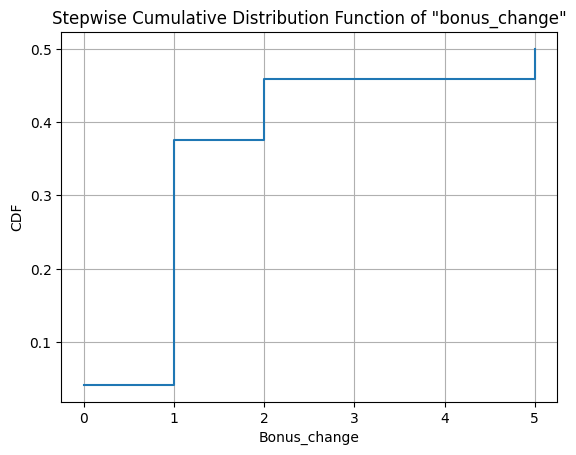

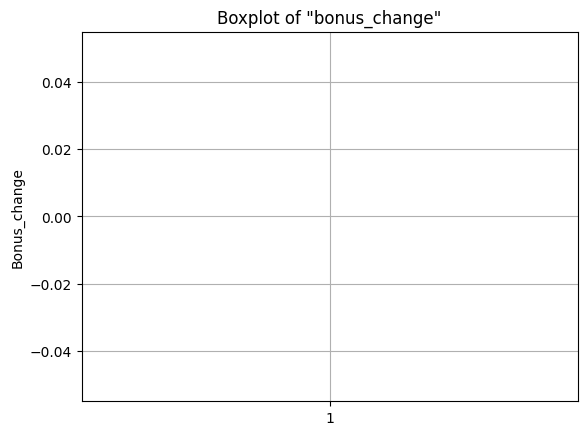

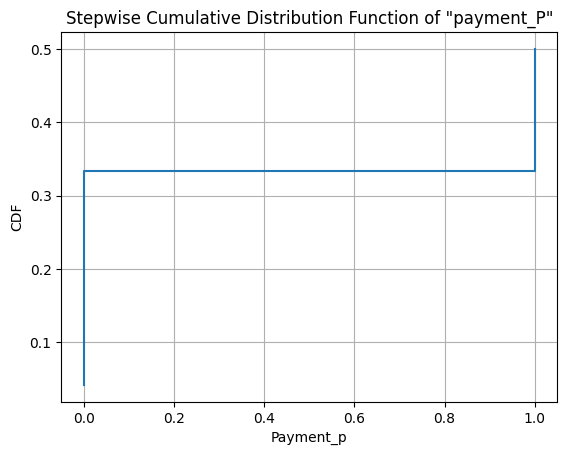

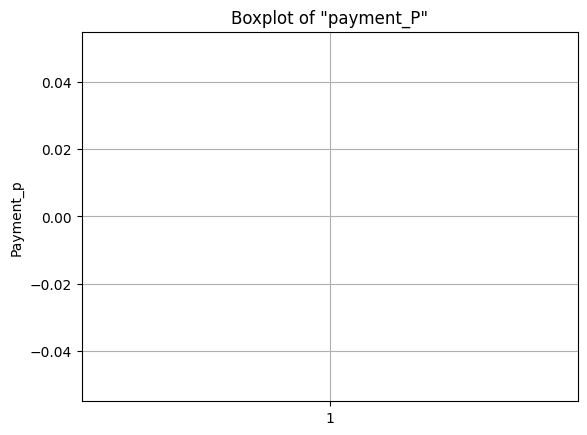

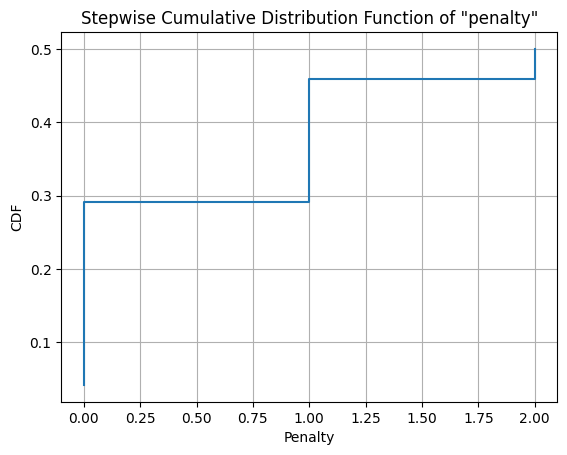

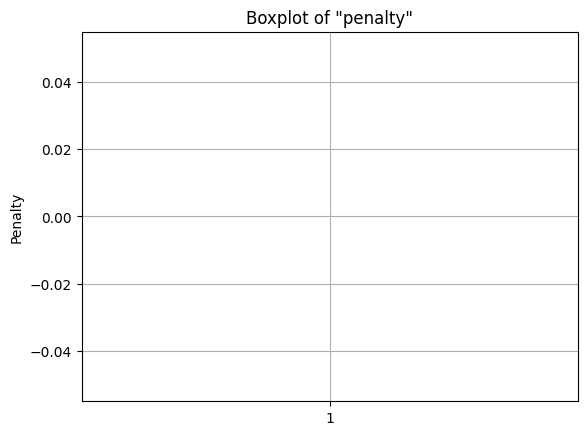

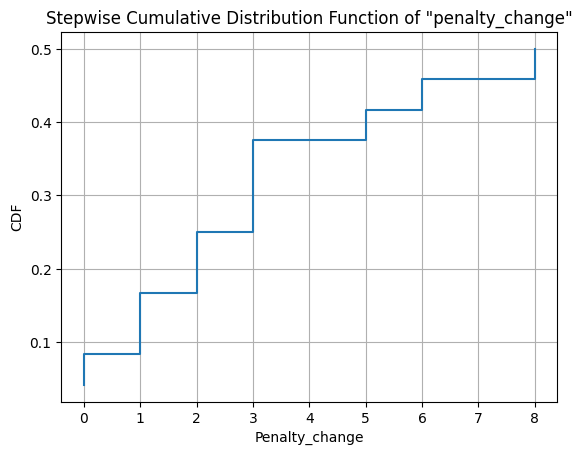

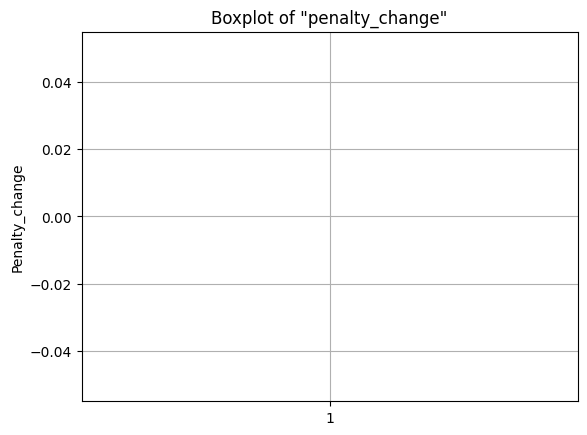

In [9]:
def plot_and_save_cdf(data, column_name, subfolder_name, by_treatment=True):
    # Create a figure and axis
    fig, ax = plt.subplots()

    if by_treatment:
        # Group the DataFrame by the "treatment" column
        grouped_data = data.groupby('treatment')[column_name]

        # Calculate and plot the stepwise CDF for each treatment group
        for treatment, group in grouped_data:
            sorted_data = np.sort(group)
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            ax.step(sorted_data, cdf, where='post', label=treatment)

        # Add legend
        ax.legend()

    else:
        # Calculate and plot the stepwise CDF for the entire dataset
        sorted_data = np.sort(data[column_name])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.step(sorted_data, cdf, where='post')

    # Add labels and title
    ax.set_xlabel(column_name.capitalize())
    ax.set_ylabel('CDF')
    ax.set_title(f'Stepwise Cumulative Distribution Function of "{column_name}"')

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'stepwise_cdf_{column_name}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

def plot_and_save_boxplot(data, column_name, subfolder_name, by_treatment=True):
    # Create a figure and axis
    fig, ax = plt.subplots()

    if by_treatment:
        # Data for boxplot
        treatment_values = data['treatment'].unique()
        data_to_plot = [data[data['treatment'] == treatment][column_name] for treatment in treatment_values]

        # Create the boxplots
        ax.boxplot(data_to_plot, labels=treatment_values)

    else:
        # Data for boxplot
        data_to_plot = data[column_name]

        # Create the boxplot
        ax.boxplot(data_to_plot)

    # Add labels and title
    ax.set_ylabel(column_name.capitalize())
    ax.set_title(f'Boxplot of "{column_name}"')

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the boxplot in the subfolder
    file_path = os.path.join(subfolder_path, f'boxplot_{column_name}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

# Call the function to plot and save the CDF for 'num_draws'
plot_and_save_cdf(data, 'num_draws', subfolder_name)

# Call the function to plot and save the CDF for 'time_task'
plot_and_save_cdf(data, 'task_duration', subfolder_name)

# Call the function to plot and save the CDF for 'payoff'
plot_and_save_cdf(data, 'payoff', subfolder_name)

# Call the function to plot and save the CDF for 'expected_bonus'
plot_and_save_cdf(data, 'expected_bonus', subfolder_name)

# Call the function to plot and save the CDF for 'mistakes_total'
plot_and_save_cdf(data, 'mistakes_total', subfolder_name)


# Call the function to plot and save the boxplot for 'num_draws'
plot_and_save_boxplot(data, 'num_draws', subfolder_name)

# Call the function to plot and save the boxplot for 'time_task'
plot_and_save_boxplot(data, 'task_duration', subfolder_name)

# Call the function to plot and save the boxplot for 'payoff'
plot_and_save_boxplot(data, 'payoff', subfolder_name)

# Call the function to plot and save the boxplot for 'expected_bonus'
plot_and_save_boxplot(data, 'expected_bonus', subfolder_name)

# Call the function to plot and save the boxplot for 'mistakes_total'
plot_and_save_boxplot(data, 'mistakes_total', subfolder_name)





# Call the function to plot and save the CDF for 'study_duration'
plot_and_save_cdf(data, 'study_duration', subfolder_name, by_treatment=False)


# Call the function to plot and save the boxplot for 'study_duration'
plot_and_save_boxplot(data, 'study_duration', subfolder_name, by_treatment=False)


for question in ['payment_B', 'bonus', 'bonus_change'] + ['payment_P', 'penalty', 'penalty_change']:
    # Call the function to plot and save the CDF for question
    plot_and_save_cdf(data, question, subfolder_name, by_treatment=False)

    # Call the function to plot and save the boxplot for question
    plot_and_save_boxplot(data, question, subfolder_name, by_treatment=False)



### Calculate the value of one more draw. 

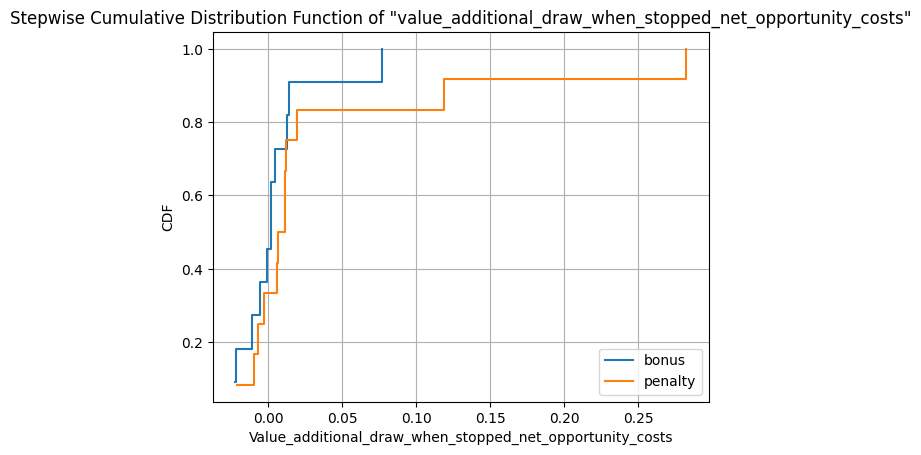

In [92]:
NUM_BOXES = 10000
NUM_DRAWS = 1000
START_VALUE = 1
END_VALUE = 9
INCREMENT_VALUE = 0.01

data=data[data['num_draws']<=300]

# Functions copied from the oTree experiment to create the list of boxes
def create_incremented_array(start, end, increment, callback):
    array = []
    i = start
    while i <= end:
        array.append(callback(i))
        i += increment
    return array

def manipulate_array(array, total_sum):
    # Step 1: Calculate the sum of all elements
    sum_value = sum(array)

    # Step 2: Calculate the ratio
    ratio = total_sum / sum_value

    # Step 3: Multiply each element by the ratio
    multiplied_array = [value * ratio for value in array]

    # Step 4: Round each element to the nearest integer
    rounded_array = [round(value) for value in multiplied_array]

    # Step 5: Adjust rounding errors
    rounded_sum = sum(rounded_array)
    difference = total_sum - rounded_sum

    if difference > 0:
        # Rounded sum is too small, find elements where rounded number is the most smaller than the actual number
        rounding_errors = [value - rounded_array[index] if value > rounded_array[index] else 0 for index, value in enumerate(multiplied_array)]
        adjustment = 1
    elif difference < 0:
        # Rounded sum is too large, find elements where rounded number is the most larger than the actual number
        rounding_errors = [rounded_array[index] - value if value < rounded_array[index] else 0 for index, value in enumerate(multiplied_array)]
        adjustment = -1
    else:
        # Rounded sum is already equal to total_sum, no adjustment needed
        return rounded_array

    # Sort rounding errors in descending order and find the indices of the largest ones
    largest_rounding_error_indices = sorted(range(len(rounding_errors)), key=lambda i: rounding_errors[i], reverse=True)[:abs(difference)]

    # Split the difference equally among the elements with the largest rounding errors
    adjusted_array = [value + (adjustment if index in largest_rounding_error_indices else 0) for index, value in enumerate(rounded_array)]

    return adjusted_array

# create labels
first_array =  create_incremented_array(START_VALUE, END_VALUE, INCREMENT_VALUE, lambda i: i)
labels =  ["{:.2f}".format(num) for num in first_array]
minimum_payoff = float(min(labels))

# create list of boxes
first_array= create_incremented_array(START_VALUE, END_VALUE, INCREMENT_VALUE, lambda i: math.exp(-1.75 * i))
sum_value = sum(first_array)
ratio = NUM_BOXES / sum_value
first_array = [value * ratio for value in first_array]
step = 10
for i in range(len(first_array)):
        if i %  step == 0:
            first_array[i] = max([1,first_array[i]])

boxes_per_label = manipulate_array(first_array,NUM_BOXES)
list_of_boxes = [float(a) for a, b in zip(labels, boxes_per_label) for _ in range(b)]

# Function to calculate value of additional draws
def calculate_value_of_additional_draws(row):
    initial_list = list_of_boxes.copy()
    initial_list = [x for x in initial_list]
    num_draws = int(row["num_draws"])
    opened_boxes = row["sequence"][:num_draws]
    opened_boxes = [float(x) for x in opened_boxes]
    value_additional_draws = []
    for i in range(num_draws+1):
        pretend_open_boxes = opened_boxes[:i]
        if i>0: 
            payoff = payoff = max(pretend_open_boxes)
            initial_list.remove(opened_boxes[i-1])
        else:
            payoff = minimum_payoff
        new_list = [max(payoff, element) for element in initial_list]
        expected_payoff_one_draw = sum(new_list)/len(new_list)
        value_one_draw = expected_payoff_one_draw - payoff
        value_additional_draws.append(value_one_draw)
    return value_additional_draws
   
# Apply the function to each row
data["value_additional_draw"] = data.apply(calculate_value_of_additional_draws, axis=1)
data["value_additional_draw_when_stopped"] = data["value_additional_draw"].apply(lambda lst: lst[-1])
data["value_additional_draw_when_stopped_net_opportunity_costs"] = data["value_additional_draw_when_stopped"] - opportunity_cost

# Constants related to opportunity cost
hour_opportunity_cost= 8
second_opportunity_cost = hour_opportunity_cost/3600
delay = 10
opportunity_cost = second_opportunity_cost*delay

# Call the function to plot and save the CDF for 'value_additional_draw_when_stopped_net_opportunity_costs'
plot_and_save_cdf(data, 'value_additional_draw_when_stopped_net_opportunity_costs', subfolder_name)

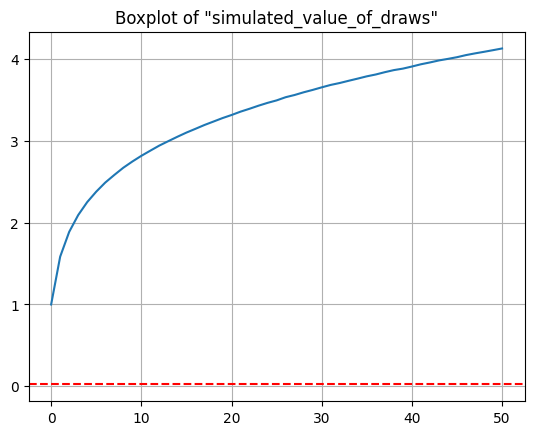

In [105]:
# Calculate unconditional value of opening boxess.
import random 

num_simulations = 1000000
num_simulated_draws = 50
def simulate_max_draws(draws):
    max_elements = []
    if draws >0:
        for _ in range(num_simulations):
            drawn_elements = random.sample(list_of_boxes, draws)
            max_element = max(drawn_elements)
            max_elements.append(max_element)
        average_max = sum(max_elements) / len(max_elements)
    else:
        average_max = minimum_payoff
    return average_max

# Perform simulations for different numbers of draws
simulation_results = []
simulated_draws = []
for draws in range(0, num_simulated_draws + 1):
    simulated_draws.append(draws)
    simulation_results.append(simulate_max_draws(draws))


def plot_and_save_lineplot(x_values,y_values,title,subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create the boxplot
    ax.plot(x_values, y_values)

    # Add a horizontal line for opportunity_cost
    ax.axhline(y=opportunity_cost, color='r', linestyle='--', label='Opportunity Cost')

    # Add labels and title
    ax.set_title(f'Boxplot of "{title}"')

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the boxplot in the subfolder
    file_path = os.path.join(subfolder_path, f'line_{title}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

if False:
    plot_and_save_lineplot(simulated_draws, simulation_results, 'simulated_value_of_draws', subfolder_name)

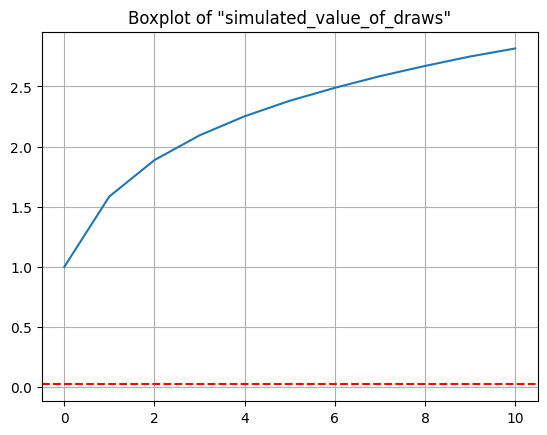